# 프로젝트 : ResNet Ablation Study
shortcut connection을 이용해 더 깊은 모델에서도 안정적으로 학습이 가능합니다.

shortcut이 없는 모델과 비교해보도록 하겠습니다.

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input,BatchNormalization, Conv2D, Activation, Dense, GlobalAveragePooling2D, MaxPooling2D, ZeroPadding2D, Add, AveragePooling2D,Flatten

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
# 0 ~ 1(또는 -1 ~ 1) 사이의 실수값으로 정규화한다.
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [32, 32])
    return tf.cast(image, tf.float32) / 255., label

#  전체 데이터셋을 모두 정규화한다.
def apply_normalize_on_dataset(ds, is_test=False, batch_size=8):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [3]:
BATCH_SIZE = 100
EPOCH = 100
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
print(len(ds_train))
print(len(ds_test))
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

50000
10000


### ResNet 34의 블록을 생성하는 함수를 정의합니다.
이전 레이어에서 처음 데이터를 받았다면 크기가 절반이 되어있어 숏컷과 Add연산이 불가능합니다.

따라서 이전 레이어로부터 처음 받은 블록에서는 숏컷의 크기를 조절할 필요가 있습니다.

In [4]:
#ResNet 34의 블록 생성 함수
def basic_block(input,channel,i,stride=1):
    x = input
    shortcut = input
    st = stride if i==0 else 1
    output = Conv2D(filters=channel,kernel_size=(3,3),strides=st,padding='same')(x)
    output = BatchNormalization()(output)
    output = Activation('relu')(output)

    output = Conv2D(filters=channel,kernel_size=(3,3),strides=1,padding='same')(output)
    output = BatchNormalization()(output)
    output = Activation('relu')(output)
    # 이전 레이어로부터 처음 받았다면 크기조절 필요
    if st != 1:
        shortcut = Conv2D(filters=channel,kernel_size=(1,1),strides=2,padding='same')(shortcut)
    shortcut = BatchNormalization()(shortcut)
    output = Add()([output,shortcut])

    return output

In [5]:
def ResNet34(num_classes = 10):
    input_layer = Input(shape=(32, 32, 3))
    output = Conv2D(filters=64,kernel_size=(3,3),strides=2,padding='same')(input_layer)
    output = BatchNormalization()(output)
    output = MaxPooling2D(pool_size=(3,3),strides=2,padding='same')(output)
    filter = [64,128,256,512]
    num = [3,4,6,3]
    s = 1
    for n,f in zip(num,filter):
        for i in range(n):
            output = basic_block(output,f,i,s)
        s+=1
        if s>=2 : s=2
    
    
    output = AveragePooling2D(pool_size=(1,1))(output)
    output = Flatten(name='flatten')(output)
    output = Dense(num_classes, activation='softmax', name='predictions')(output)

    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    
    return model 

In [6]:
resnet34 = ResNet34()
resnet34.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 64)   1792        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 16, 16, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 8, 8, 64)     0           ['batch_normalization[0][0]']

In [7]:
resnet34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_34 = resnet34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/100
500/500 [==============================] - 53s 63ms/step - loss: 1.8484 - accuracy: 0.3759 - val_loss: 1.9755 - val_accuracy: 0.3130
Epoch 2/100
500/500 [==============================] - 29s 58ms/step - loss: 1.3139 - accuracy: 0.5335 - val_loss: 1.4691 - val_accuracy: 0.4834
Epoch 3/100
500/500 [==============================] - 30s 60ms/step - loss: 1.0209 - accuracy: 0.6440 - val_loss: 1.3421 - val_accuracy: 0.5332
Epoch 4/100
500/500 [==============================] - 29s 58ms/step - loss: 0.7200 - accuracy: 0.7616 - val_loss: 1.4089 - val_accuracy: 0.5284
Epoch 5/100
500/500 [==============================] - 29s 59ms/step - loss: 0.4393 - accuracy: 0.8632 - val_loss: 1.4929 - val_accuracy: 0.5501
Epoch 6/100
500/500 [==============================] - 30s 59ms/step - loss: 0.2384 - accuracy: 0.9324 - val_loss: 1.7684 - val_accuracy: 0.5295
Epoch 7/100
500/500 [==============================] - 30s 59ms/step - loss: 0.1247 - accuracy: 0.9667 - val_loss: 1.9572 - val_ac

### shortcut X
비교를 위해 shortcut connection을 제외한 네트워크를 정의합니다.

In [8]:
#plane 34
def plane_block(input,channel,i,stride=1):
    x = input
    st = stride if i==0 else 1
    output = Conv2D(filters=channel,kernel_size=(3,3),strides=st,padding='same')(x)
    output = BatchNormalization()(output)
    output = Activation('relu')(output)

    output = Conv2D(filters=channel,kernel_size=(3,3),strides=1,padding='same')(output)
    output = BatchNormalization()(output)
    output = Activation('relu')(output)

    return output

def PlaneNet34(num_classes = 10):
    input_layer = Input(shape=(32, 32, 3))
    output = Conv2D(filters=64,kernel_size=(3,3),strides=2,padding='same')(input_layer)
    output = BatchNormalization()(output)
    output = MaxPooling2D(pool_size=(3,3),strides=2,padding='same')(output)
    filter = [64,128,256,512]
    num = [3,4,6,3]
    s = 1
    for n,f in zip(num,filter):
        for i in range(n):
            output = plane_block(output,f,i,s)
        s+=1
        if s>=2 : s=2
    
    output = AveragePooling2D(pool_size=(1,1))(output)
    output = Flatten(name='flatten')(output)
    output = Dense(num_classes, activation='softmax', name='predictions')(output)

    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    
    return model 

In [9]:
planenet34 = PlaneNet34()
planenet34.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_36 (Conv2D)          (None, 16, 16, 64)        1792      
                                                                 
 batch_normalization_49 (Bat  (None, 16, 16, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_37 (Conv2D)          (None, 8, 8, 64)          36928     
                                                                 
 batch_normalization_50 (Bat  (None, 8, 8, 64)         256 

In [10]:
planenet34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

plane_history_34 = planenet34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/100
500/500 [==============================] - 35s 57ms/step - loss: 2.3306 - accuracy: 0.1352 - val_loss: 2.4070 - val_accuracy: 0.1083
Epoch 2/100
500/500 [==============================] - 28s 56ms/step - loss: 2.0775 - accuracy: 0.2147 - val_loss: 2.0224 - val_accuracy: 0.2503
Epoch 3/100
500/500 [==============================] - 28s 56ms/step - loss: 1.8157 - accuracy: 0.3225 - val_loss: 1.8175 - val_accuracy: 0.3110
Epoch 4/100
500/500 [==============================] - 28s 57ms/step - loss: 1.6037 - accuracy: 0.4038 - val_loss: 1.5768 - val_accuracy: 0.4274
Epoch 5/100
500/500 [==============================] - 28s 57ms/step - loss: 1.4437 - accuracy: 0.4706 - val_loss: 1.5028 - val_accuracy: 0.4634
Epoch 6/100
500/500 [==============================] - 28s 57ms/step - loss: 1.3186 - accuracy: 0.5215 - val_loss: 1.4916 - val_accuracy: 0.4690
Epoch 7/100
500/500 [==============================] - 29s 57ms/step - loss: 1.2185 - accuracy: 0.5612 - val_loss: 1.3843 - val_ac

### 시각화
loss가 확실히 빠르게 감소합니다.

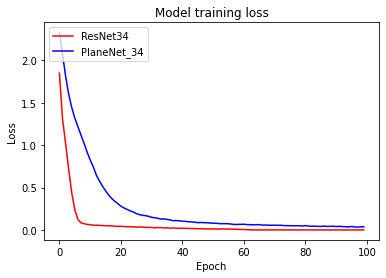

In [11]:
import matplotlib.pyplot as plt

plt.plot(history_34.history['loss'], 'r')
plt.plot(plane_history_34.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet34', 'PlaneNet_34'], loc='upper left')
plt.show()

### ResNet50
이번엔 모델 구조를 자세히 파악하기 위해 반복문 없이 블록을 쌓도록 했습니다.

In [12]:
def bottleneck_block(input,channel,stride=1):
    x = input
    shortcut = input
    output = Conv2D(filters=channel,kernel_size=(1,1),strides=stride,padding='same')(x)
    output = BatchNormalization()(output)
    output = Activation('relu')(output)

    output = Conv2D(filters=channel,kernel_size=(3,3),strides=1,padding='same')(output)
    output = BatchNormalization()(output)
    output = Activation('relu')(output)

    output = Conv2D(filters=(channel*4),kernel_size=(1,1),strides=1,padding='same')(output)
    output = BatchNormalization()(output)
    output = Activation('relu')(output)
    # 이전 레이어로부터 처음 받았다면 크기조절 필요
    if stride != 1:
        shortcut = Conv2D(filters=(channel*4),kernel_size=(1,1),strides=2,padding='same')(shortcut)
    else:
        shortcut = Conv2D(filters=(channel*4),kernel_size=(1,1),strides=1,padding='same')(shortcut)
    shortcut = BatchNormalization()(shortcut)
    output = Add()([output,shortcut])

    return output

레이어의 첫번째 블록에서 down sampling이 일어납니다.

In [13]:
def ResNet50(num_classes = 10):
    input_layer = Input(shape=(32, 32, 3))
    output = Conv2D(filters=64,kernel_size=(3,3),strides=2,padding='same')(input_layer)
    output = BatchNormalization()(output)
    output = MaxPooling2D(pool_size=(3,3),strides=2,padding='same')(output)

    output = bottleneck_block(output,64,1)
    output = bottleneck_block(output,64,1)
    output = bottleneck_block(output,64,1)

    output = bottleneck_block(output,128,2)
    output = bottleneck_block(output,128,1)
    output = bottleneck_block(output,128,1)
    output = bottleneck_block(output,128,1)

    output = bottleneck_block(output,256,2)
    output = bottleneck_block(output,256,1)
    output = bottleneck_block(output,256,1)
    output = bottleneck_block(output,256,1)
    output = bottleneck_block(output,256,1)
    output = bottleneck_block(output,256,1)

    output = bottleneck_block(output,512,2)
    output = bottleneck_block(output,512,1)
    output = bottleneck_block(output,512,1)

    output = AveragePooling2D(pool_size=(1,1))(output)
    output = Flatten(name='flatten')(output)
    output = Dense(num_classes, activation='softmax', name='predictions')(output)

    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )

    return model

In [14]:
resnet50 = ResNet50()
resnet50.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_69 (Conv2D)             (None, 16, 16, 64)   1792        ['input_3[0][0]']                
                                                                                                  
 batch_normalization_82 (BatchN  (None, 16, 16, 64)  256         ['conv2d_69[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 8, 8, 64)    0           ['batch_normalization_82[0]

In [15]:
resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_50 = resnet50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/100
500/500 [==============================] - 69s 111ms/step - loss: 2.1993 - accuracy: 0.2756 - val_loss: 2.0642 - val_accuracy: 0.2654
Epoch 2/100
500/500 [==============================] - 55s 110ms/step - loss: 1.7767 - accuracy: 0.3798 - val_loss: 1.8951 - val_accuracy: 0.3752
Epoch 3/100
500/500 [==============================] - 56s 111ms/step - loss: 1.5871 - accuracy: 0.4416 - val_loss: 1.8556 - val_accuracy: 0.4011
Epoch 4/100
500/500 [==============================] - 56s 111ms/step - loss: 1.4324 - accuracy: 0.4921 - val_loss: 1.5775 - val_accuracy: 0.4507
Epoch 5/100
500/500 [==============================] - 58s 115ms/step - loss: 1.2821 - accuracy: 0.5426 - val_loss: 1.5137 - val_accuracy: 0.4852
Epoch 6/100
500/500 [==============================] - 56s 111ms/step - loss: 1.1283 - accuracy: 0.6008 - val_loss: 1.3828 - val_accuracy: 0.5266
Epoch 7/100
500/500 [==============================] - 56s 111ms/step - loss: 0.9583 - accuracy: 0.6620 - val_loss: 1.3440 -

### shortcut X
역시 shortcut connection을 제외한 네트워크를 정의합니다.

In [16]:
def plane_bottleneck_block(input,channel,stride=1):
    x = input
    output = Conv2D(filters=channel,kernel_size=(1,1),strides=stride,padding='same')(x)
    output = BatchNormalization()(output)
    output = Activation('relu')(output)

    output = Conv2D(filters=channel,kernel_size=(3,3),strides=1,padding='same')(output)
    output = BatchNormalization()(output)
    output = Activation('relu')(output)

    output = Conv2D(filters=(channel*4),kernel_size=(1,1),strides=1,padding='same')(output)
    output = BatchNormalization()(output)
    output = Activation('relu')(output)

    return output

def PlaneNet50(num_classes = 10):
    input_layer = Input(shape=(32, 32, 3))
    output = Conv2D(filters=64,kernel_size=(3,3),strides=2,padding='same')(input_layer)
    output = BatchNormalization()(output)
    output = MaxPooling2D(pool_size=(3,3),strides=2,padding='same')(output)

    output = plane_bottleneck_block(output,64,1)
    output = plane_bottleneck_block(output,64,1)
    output = plane_bottleneck_block(output,64,1)

    output = plane_bottleneck_block(output,128,2)
    output = plane_bottleneck_block(output,128,1)
    output = plane_bottleneck_block(output,128,1)
    output = plane_bottleneck_block(output,128,1)

    output = plane_bottleneck_block(output,256,2)
    output = plane_bottleneck_block(output,256,1)
    output = plane_bottleneck_block(output,256,1)
    output = plane_bottleneck_block(output,256,1)
    output = plane_bottleneck_block(output,256,1)
    output = plane_bottleneck_block(output,256,1)

    output = plane_bottleneck_block(output,512,2)
    output = plane_bottleneck_block(output,512,1)
    output = plane_bottleneck_block(output,512,1)

    output = AveragePooling2D(pool_size=(1,1))(output)
    output = Flatten(name='flatten')(output)
    output = Dense(num_classes, activation='softmax', name='predictions')(output)

    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )

    return model

In [17]:
planenet50 = PlaneNet50()
planenet50.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_134 (Conv2D)         (None, 16, 16, 64)        1792      
                                                                 
 batch_normalization_147 (Ba  (None, 16, 16, 64)       256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_135 (Conv2D)         (None, 8, 8, 64)          4160      
                                                                 
 batch_normalization_148 (Ba  (None, 8, 8, 64)         256 

In [18]:
planenet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

plane_history_50 = planenet50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/100
500/500 [==============================] - 38s 59ms/step - loss: 2.4443 - accuracy: 0.1072 - val_loss: 2.3680 - val_accuracy: 0.0991
Epoch 2/100
500/500 [==============================] - 29s 58ms/step - loss: 2.3604 - accuracy: 0.1129 - val_loss: 2.4417 - val_accuracy: 0.1076
Epoch 3/100
500/500 [==============================] - 29s 58ms/step - loss: 2.3304 - accuracy: 0.1152 - val_loss: 2.5274 - val_accuracy: 0.1286
Epoch 4/100
500/500 [==============================] - 29s 59ms/step - loss: 2.2889 - accuracy: 0.1312 - val_loss: 2.3866 - val_accuracy: 0.1345
Epoch 5/100
500/500 [==============================] - 29s 59ms/step - loss: 2.2523 - accuracy: 0.1477 - val_loss: 2.4112 - val_accuracy: 0.1472
Epoch 6/100
500/500 [==============================] - 29s 59ms/step - loss: 2.2032 - accuracy: 0.1688 - val_loss: 2.1982 - val_accuracy: 0.1793
Epoch 7/100
500/500 [==============================] - 29s 59ms/step - loss: 2.1270 - accuracy: 0.1948 - val_loss: 2.1227 - val_ac

### 시각화
ResNet34 보다 빠르게 loss가 감소하였고 정확도 역시 꽤 많이 올라갔습니다.

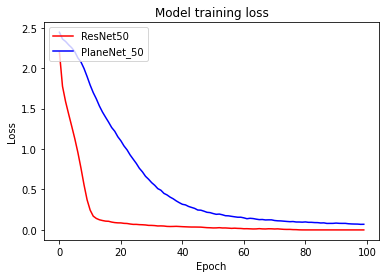

In [19]:
plt.plot(history_50.history['loss'], 'r')
plt.plot(plane_history_50.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet50', 'PlaneNet_50'], loc='upper left')
plt.show()

# 회고합시다.
단순히 인풋으로 받은 데이터를 아웃풋과 합쳐줬을 뿐인데 성능이 크게 상승했습니다.

처음 논문을 보고 모델을 직접 구현해 보았는데 좀 어렵지만 나름 설명서보고 조립하는 느낌이라 생각보다 재미있었습니다.